# Informe Proyecto Machine Learning 2022.

## Integrantes

- Javier E. Domínguez Hernández C-412
- David Orlando De Quesada Oliva C-411
- Andrés Alejandro León Almaguer C-412


### El problema

Nuestro proyecto se enfoca en el problema de tratar de predecir cuando un vehículo en 
su trayecto por la vía, se encuentra con una anomalía (bache, juntas de expansión, líneas de tren, banda de frenado, etc). 

### La propuesta y los datos
	
Nuestra propuesta es utilizar los sensores de los teléfonos móviles como el acelerómetro, el giroscopio y el GPS
para construir un modelo de Machine Learning que sea capaz de predecir la ocurrencia de estos eventos mientras el 
vehículo está en movimiento. Inicialmente nuestra idea es analizar los datos del acelerómetro en los tres ejes del
dispositivo, el X (que va de un lado a otro del dispositivo), Y (que va de la parte de abajo hacia la parte de arriba del móvil) y
Z (que atraviesa la pantalla del móvil de un lado a otro). Con la hipótesis de que una verdadera anomalía en un intervalo de tiempo
produce un pico en la señal del acelerómetro (serie temporal) en el eje Z, pues el vehículo cae por un periodo breve de tiempo. Creemos que esta es la 
característica principal de una anomalía, pero no creemos que sea suficiente para diferenciar por ejemplo, un bache en un solo lado del vehículo
de una línea de tren. 

### Procesando los datos

In [2]:
from os import listdir, mkdir
from typing import Any
from os.path import isfile, join
from os import path
import pickle

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn import metrics  # for evaluations
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler  # for feature scaling

from tools import get_data

def make_pickle_file(file_name, data):
    with open(f"{file_name}.pickle", "wb") as outfile:
        pickle.dump(data, outfile)

def unpick_pickle_file(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    
    return data

def serialize_data(data, file_name: str):
    if not path.exists('./serialized_data'):
        mkdir('./serialized_data')

    make_pickle_file(file_name, data)

def deserialize_data(file_name):
    if path.exists(file_name):
        data = unpick_pickle_file(file_name)
        return data
    
    else: return None

def load_data_json():
    json_files = [
        f"./data/{file}" for file in listdir("./data") if isfile(join("./data", file))
    ]

    file1 = json_files[0]
    first = pd.read_json(file1)
    merged_raw_data = first

    for file in json_files[1:]:
        json_readed = pd.read_json(file)
        merged_raw_data = pd.concat([merged_raw_data, json_readed], axis=0)

    accel_raw = merged_raw_data[["accelerometer"]].copy()
    speed_raw = merged_raw_data[["speed"]].copy()

    data_procc = []

    for index in range(len(accel_raw)):
        for list in accel_raw.iloc[index]:
            data_procc.append([elem for elem in list])

        data_procc[-1].append(speed_raw.iloc[index][0])

    procc_df = pd.DataFrame(data_procc, columns=["Accel X", "Accel Y", "Accel Z", "Speed"])
    procc_df = procc_df[procc_df["Speed"] > 0]
    procc_df["Z/X"] =   procc_df["Accel Z"] / procc_df["Accel X"]
    procc_df["Z/Speed"] = procc_df["Accel Z"] / procc_df["Speed"]

    procc_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    procc_df.dropna(inplace=True)


    serialize_data(procc_df, './serialized_data/data_df')
    return procc_df

procc_df = deserialize_data('./serialized_data/data_df.pickle')
if not isinstance(procc_df, pd.DataFrame):
    procc_df = load_data_json()

## Aceleración Eje Z vs Aceleración Eje X

### Datos sin normalizar.

#### Datos Aleatorios 10%

In [3]:
z_vs_x = procc_df.sample(frac=.10)
z_vs_x = z_vs_x[["Accel X", "Accel Z"]]

values = z_vs_x.values

Mean Silhouette score: 0.4168266410087107


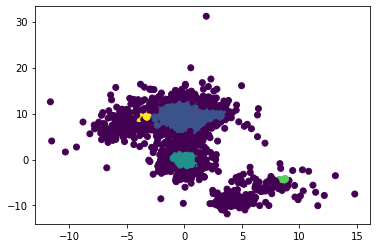

In [5]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(z_vs_x, y_pred)))


#### Datos Aleatorios 25%

In [6]:
z_vs_x = procc_df.sample(frac=.25)
z_vs_x = z_vs_x[["Accel X", "Accel Z"]]

values = z_vs_x.values

Mean Silhouette score: 0.5531675582766545


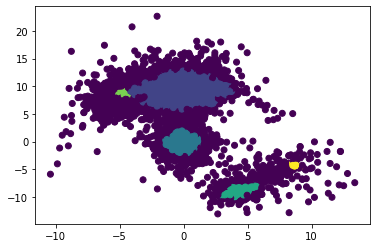

In [7]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(z_vs_x, y_pred)))

#### Datos aleatorios 35%

In [8]:
z_vs_x = procc_df.sample(frac=.35)
z_vs_x = z_vs_x[["Accel X", "Accel Z"]]

values = z_vs_x.values

Mean Silhouette score: 0.575820658806709


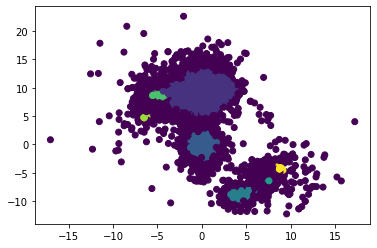

In [9]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(z_vs_x, y_pred)))

Como podemos ver para datos no normalizados de acceleracción en el eje z vs aceleración en el eje x, los clusters tienen una calidad promedio.

### Datos normalizados

#### Datos aleatorios 10%

In [10]:
z_vs_x = procc_df.sample(frac=.10)
z_vs_x = z_vs_x[["Accel X", "Accel Z"]]

values = z_vs_x.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.7069568980347608


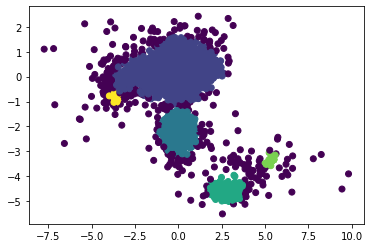

In [11]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(z_vs_x, y_pred)))

In [12]:
z_vs_x = procc_df.sample(frac=.25)
z_vs_x = z_vs_x[["Accel X", "Accel Z"]]

values = z_vs_x.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.709880175628544


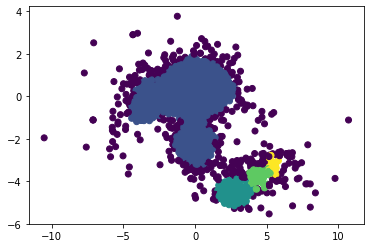

In [13]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(z_vs_x, y_pred)))

In [14]:
z_vs_x = procc_df.sample(frac=.35)
z_vs_x = z_vs_x[["Accel X", "Accel Z"]]

values = z_vs_x.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.7194059697632541


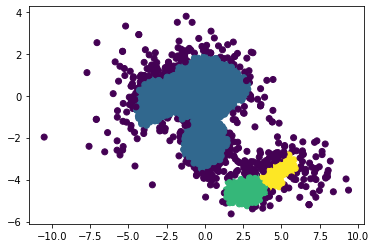

In [15]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(z_vs_x, y_pred)))

Para los datos normalizados la calidad de los clusters es bastante mejor que la de los clusters para los datos sin normalizar, aunque debemos analizar y poner en
contexto que significado tendría para nosotros normalizar los datos, y si sería bueno o no para el modelo que pretendemos construir.

## Velocidad vs aceleración Eje Z

### Datos sin normalizar

#### Datos aleatorios 10%

In [16]:
speed_vs_z = procc_df.sample(frac=.10)
speed_vs_z = speed_vs_z[["Speed", "Accel Z"]]

values = speed_vs_z.values

Mean Silhouette score: -0.4034912085505971


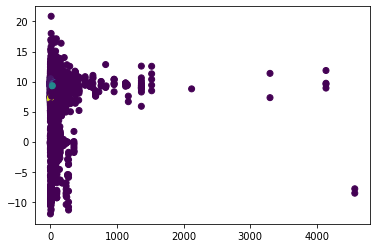

In [17]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(speed_vs_z, y_pred)))

#### Datos aleatorios 25%

In [18]:
speed_vs_z = procc_df.sample(frac=.25)
speed_vs_z = speed_vs_z[["Speed", "Accel Z"]]

values = speed_vs_z.values

Mean Silhouette score: -0.65457622624097


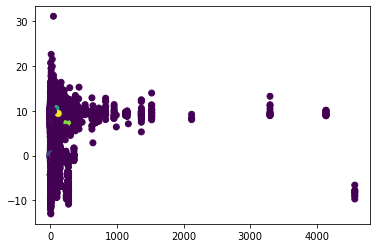

In [19]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(speed_vs_z, y_pred)))

#### Datos aleatorios 35%

In [20]:
speed_vs_z = procc_df.sample(frac=.35)
speed_vs_z = speed_vs_z[["Speed", "Accel Z"]]

values = speed_vs_z.values

Mean Silhouette score: -0.6318637446538654


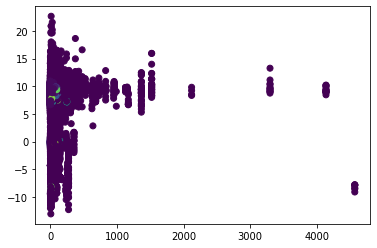

In [21]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(speed_vs_z, y_pred)))

La velocidad es una característica que depende de las lecturas del GPS que obtengamos, y es un feature que ahora mismo no es muy bueno quizá porque neesitamos pulir la forma
de obtener los datos de forma más precisa.

### Datos normalizados

#### Datos aleatorios 10%

In [22]:
speed_vs_z = procc_df.sample(frac=.10)
speed_vs_z = speed_vs_z[["Speed", "Accel Z"]]

values = speed_vs_z.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.05025919115975973


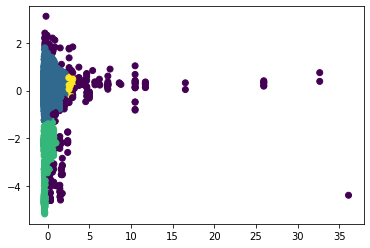

In [23]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(speed_vs_z, y_pred)))

#### Datos aleatorios 25%

In [24]:
speed_vs_z = procc_df.sample(frac=.25)
speed_vs_z = speed_vs_z[["Speed", "Accel Z"]]

values = speed_vs_z.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.894587015354982


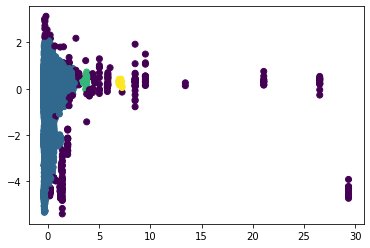

In [25]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(speed_vs_z, y_pred)))

#### Datos aleatorios 35%

In [26]:
speed_vs_z = procc_df.sample(frac=.30)
speed_vs_z = speed_vs_z[["Speed", "Accel Z"]]

values = speed_vs_z.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.8945828012476648


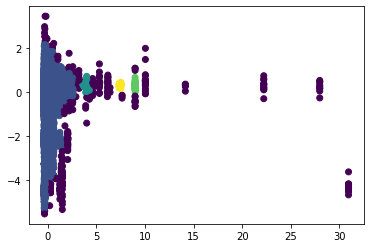

In [27]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(speed_vs_z, y_pred)))

Como mencionamos anteriormente este feature tenemos que corregirlo y realizar un análisis en el futuro para decidir en que momento de la elaboración del modelo
semi-supervisado que pretendemos construir sería mejor incorporarlo.

## Cociente Accel Z/Speed vs cociente Accel Z/Accel X

### Datos sin normalizar 

#### Datos aleatorios 10%

In [28]:

zspeed_vs_zx = procc_df.sample(frac=.10)
zspeed_vs_zx = zspeed_vs_zx[["Z/Speed", "Z/X"]]

values = zspeed_vs_zx.values
print(procc_df)

         Accel X  Accel Y  Accel Z       Speed        Z/X   Z/Speed
23     -6.231690  6.12427  4.16870  166.844700  -0.668952  0.024986
24     -6.059570  6.38550  4.39697  166.844700  -0.725624  0.026354
25     -6.005860  6.13159  4.68018  166.844700  -0.779269  0.028051
26     -6.103520  5.86426  4.28711  166.844700  -0.702400  0.025695
27     -6.162110  6.53564  5.39673  166.844700  -0.875793  0.032346
...          ...      ...      ...         ...        ...       ...
207448 -0.440674  5.20508  8.58643    1.359998 -19.484767  6.313561
207449 -0.603027  5.10620  8.59741    1.359998 -14.257090  6.321634
207463 -1.326900  3.21167  9.28223  836.238600  -6.995425  0.011100
207464 -1.383060  3.64136  9.17725  836.238600  -6.635468  0.010974
207465 -1.607670  3.90747  9.96582  836.238600  -6.198921  0.011917

[155852 rows x 6 columns]


Mean Silhouette score: -0.5958651288403534


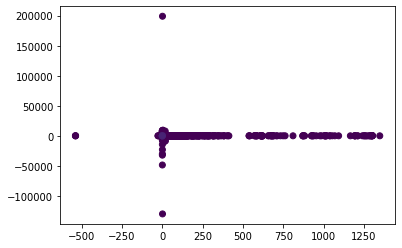

In [29]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(zspeed_vs_zx, y_pred)))

####  Datos aleatorios 25 %

In [30]:
zspeed_vs_zx = procc_df.sample(frac=.25)
zspeed_vs_zx = zspeed_vs_zx[["Z/Speed", "Z/X"]]

values = zspeed_vs_zx.values
print(procc_df)

         Accel X  Accel Y  Accel Z       Speed        Z/X   Z/Speed
23     -6.231690  6.12427  4.16870  166.844700  -0.668952  0.024986
24     -6.059570  6.38550  4.39697  166.844700  -0.725624  0.026354
25     -6.005860  6.13159  4.68018  166.844700  -0.779269  0.028051
26     -6.103520  5.86426  4.28711  166.844700  -0.702400  0.025695
27     -6.162110  6.53564  5.39673  166.844700  -0.875793  0.032346
...          ...      ...      ...         ...        ...       ...
207448 -0.440674  5.20508  8.58643    1.359998 -19.484767  6.313561
207449 -0.603027  5.10620  8.59741    1.359998 -14.257090  6.321634
207463 -1.326900  3.21167  9.28223  836.238600  -6.995425  0.011100
207464 -1.383060  3.64136  9.17725  836.238600  -6.635468  0.010974
207465 -1.607670  3.90747  9.96582  836.238600  -6.198921  0.011917

[155852 rows x 6 columns]


Mean Silhouette score: -0.6130354129757116


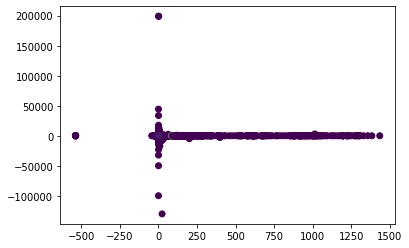

In [31]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(zspeed_vs_zx, y_pred)))

#### Datos aleatorios 35%

In [3]:
zspeed_vs_zx = procc_df.sample(frac=.35)
zspeed_vs_zx = zspeed_vs_zx[["Z/Speed", "Z/X"]]

values = zspeed_vs_zx.values

Mean Silhouette score: -0.4686794917360623


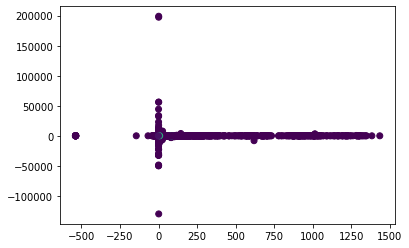

In [33]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(zspeed_vs_zx, y_pred)))

### Datos normalizados

#### Datos aleatorios 10%

In [34]:
zspeed_vs_zx = procc_df.sample(frac=.10)
zspeed_vs_zx = zspeed_vs_zx[["Z/Speed", "Z/X"]]
values = zspeed_vs_zx.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.9501005638654911


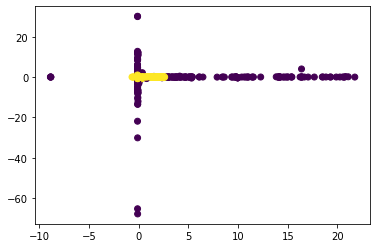

In [35]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(zspeed_vs_zx, y_pred)))

Para poder tomar una decisión sobre como y cuando usar este feature en el modelo, debemos tener valores de velocidad lo más precisos posible, y como mencionamos previamente
es algo que pretendemos mejorar más adelante

## Aceleración Eje Y vs Aceleración Eje Z

### Datos sin normalizar

#### Datos aleatorios 10%

In [ ]:

y_vs_z = procc_df.sample(frac=.10)
y_vs_z = y_vs_z[["Accel Y", "Accel Z"]]

values = y_vs_z.values

Mean Silhouette score: 0.38507712077552914


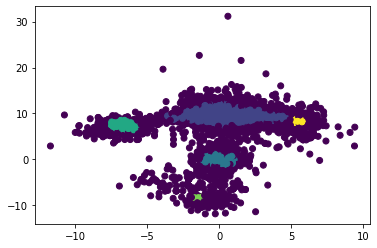

In [ ]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(y_vs_z, y_pred)))

#### Datos aleatorios 25%

In [ ]:

y_vs_z = procc_df.sample(frac=.25)
y_vs_z = y_vs_z[["Accel Y", "Accel Z"]]

values = y_vs_z.values

Mean Silhouette score: 0.3908466683142022


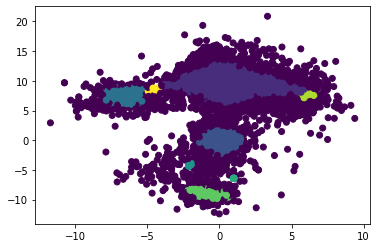

In [ ]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(y_vs_z, y_pred)))

#### Datos aleatorios 35%

In [5]:

y_vs_z = procc_df.sample(frac=.35)
y_vs_z = y_vs_z[["Accel Y", "Accel Z"]]

values = y_vs_z.values

Mean Silhouette score: 0.5704886959522554


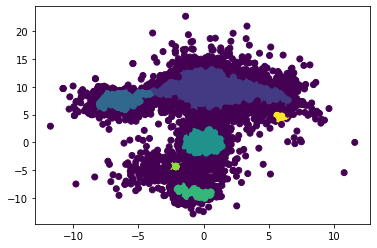

In [6]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(y_vs_z, y_pred)))

Los datos sin normalizar del acelerómetro en los ejes Y y Z no dan una mala calidad de los clústers pero están por debajo de la calidad de los clusters de la aceleración 
en los ejes Z y X.

### Datos normalizados


#### Datos aleatorios 10%

In [ ]:
y_vs_z = procc_df.sample(frac=.10)
y_vs_z = y_vs_z[["Accel Y", "Accel Z"]]
values = y_vs_z.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.6666551174537049


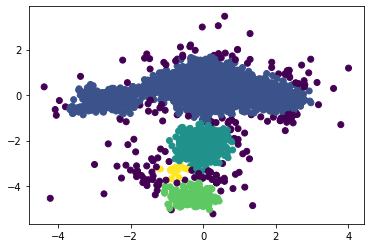

In [ ]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(y_vs_z, y_pred)))

#### Datos aleatorios 25%

In [ ]:
y_vs_z = procc_df.sample(frac=.25)
y_vs_z = y_vs_z[["Accel Y", "Accel Z"]]
values = y_vs_z.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.602121326791296


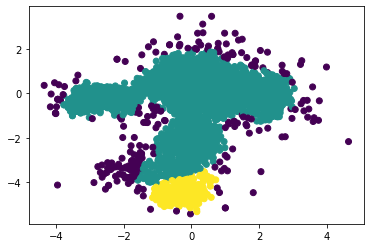

In [ ]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(y_vs_z, y_pred)))

#### Datos aleatorios 35%

In [ ]:
y_vs_z = procc_df.sample(frac=.35)
y_vs_z = y_vs_z[["Accel Y", "Accel Z"]]
values = y_vs_z.values
values = StandardScaler().fit_transform(values)

Mean Silhouette score: 0.6194745086619178


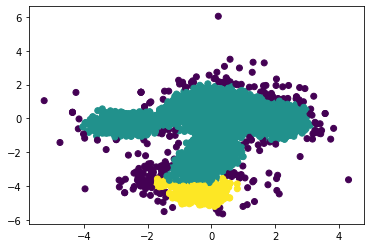

In [ ]:
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(values)
plt.scatter(values[:, 0], values[:, -1], c=y_pred)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(y_vs_z, y_pred)))

A pesar de ser un poco mejores las puntuaciones de los clusters para los datos del acelerómetro en los ejes Y y Z normalizados, estos aún se quedan por debajo de 
las puntuaciones alcanzadas por los datos del acelerómetro en los ejes Z y X.

## Conclusiones

Como planteamos en nuestra hipótesis inicial, aparentemente el valor del acelerómetro en el eje Z parece ser el feature que más información aporta (por ahora). Con este obtuvimos las mejores puntuaciones en la calidad de los clusters. Pensamos realizar más mejoras en la captura de datos, incorporar al modelo nuevas ideas, y finalmente convertirlo en un modelo semi-supervisado. 